In [2]:
import matplotlib.pyplot as plt
import yfinance as yf
import numpy as np
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

from statsmodels.tsa.stattools import acf

In [3]:
ticker = "MSFT"
# download day per day microsoft stock
data = yf.download(ticker, interval="1d", period="10y")
data.head()

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


Price,Close,High,Low,Open,Volume
Ticker,MSFT,MSFT,MSFT,MSFT,MSFT
Date,,,,,
2015-03-30,35.351482,35.852066,35.308329,35.472312,35049700
2015-03-31,35.092567,35.411904,34.989000,35.196135,34887200
2015-04-01,35.144344,35.178865,34.790484,35.040773,36865300
2015-04-02,34.773232,35.161615,34.626507,35.092568,37487500
2015-04-06,35.860703,36.059209,34.678293,34.816384,39223700


In [5]:
print(data.shape)
1/(1515)**(1/2)

(2516, 5)


0.025691749776935398

In [7]:
n= len(data)
P_train = data.iloc[:int(n*0.8)][("Open", "MSFT")]
P_test = data.iloc[int(n*0.8):][("Open", "MSFT")]
P_train.shape

(2012,)

C:\Users\Clara G\AppData\Local\Temp\ipykernel_14208\3419914365.py:4: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


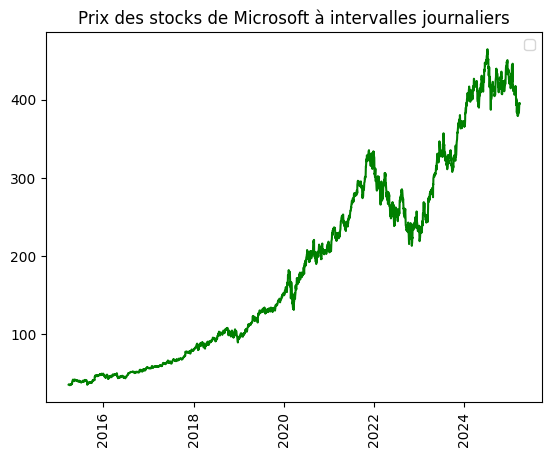

In [8]:
import matplotlib.pyplot as plt
plt.plot(np.array(data.index), data[("Open", "MSFT")].values, c="green")
plt.xticks(rotation=90)
plt.legend()
plt.title("Prix des stocks de Microsoft à intervalles journaliers")
plt.show()

On voit que bcp de variabilité sur les dernières années et très peu sur les premières. Pour stabiliser cette différence de variabilité on va prendre le log des prix

C:\Users\Clara G\AppData\Local\Temp\ipykernel_14208\1985517797.py:3: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


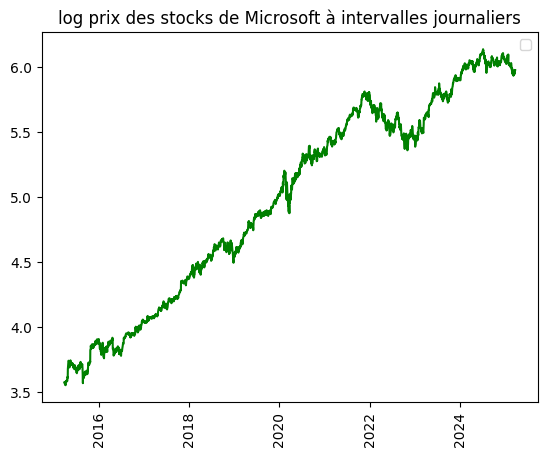

In [9]:
plt.plot(np.array(data.index), np.log(data[("Open", "MSFT")].values), c="green")
plt.xticks(rotation=90)
plt.legend()
plt.title("log prix des stocks de Microsoft à intervalles journaliers")
plt.show()

Or, si on regarde les autocorrelogrammes de cette série on voit une non-stationarisation jusqu au retard 100 au moins
LA solution à ça: prendre les premières différences (I -B)(log(Pt))

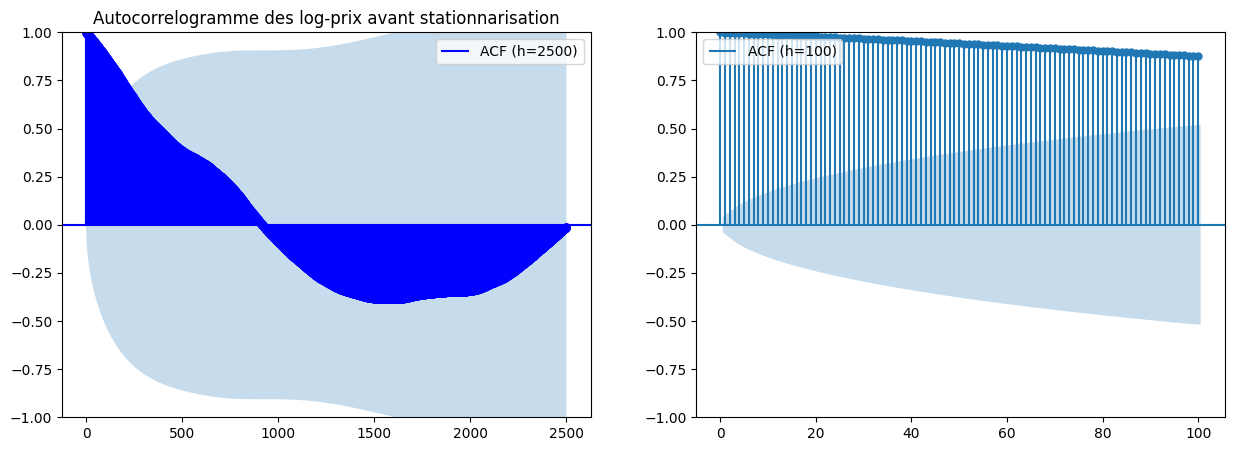

In [10]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
plot_acf(data[("Open", "MSFT")].values, ax=axes[0], alpha=.05, lags=2500, zero=False, color="blue", 
         vlines_kwargs={'colors': 'blue'})
axes[0].set_title("Autocorrelogramme des log-prix avant stationnarisation")
axes[0].legend(["ACF (h=2500)"])

plot_acf(data[("Open", "MSFT")].values, ax=axes[1], alpha=.05, lags=100, zero=True)
axes[1].set_title("")
axes[1].legend(["ACF (h=100)"])


On va prendre les différences pour stationnariser la série. En finance, la première différence du logarithme des prix d’un actif, soit  
$$
\log(P_t) - \log(P_{t-1})
$$
est appelée **le rendement logarithmique** (*log return*).

#### Définition mathématique :
$$
r_t = \log(P_t) - \log(P_{t-1}) := X_t
$$
où :
- $ P_t $ est le prix de l'actif au temps $ t $,
- $ P_{t-1} $ est le prix de l'actif à la période précédente.

#### Interprétation :
Ce rendement logarithmique est une approximation du **rendement simple** lorsqu'il est faible :
$$
r_t \approx \frac{P_t - P_{t-1}}{P_{t-1}}
$$
On voit un grand pic en 2020, le jour où le covid a été annoncé, le prix a baissé de 15% comme on peut le voir sur le graphique


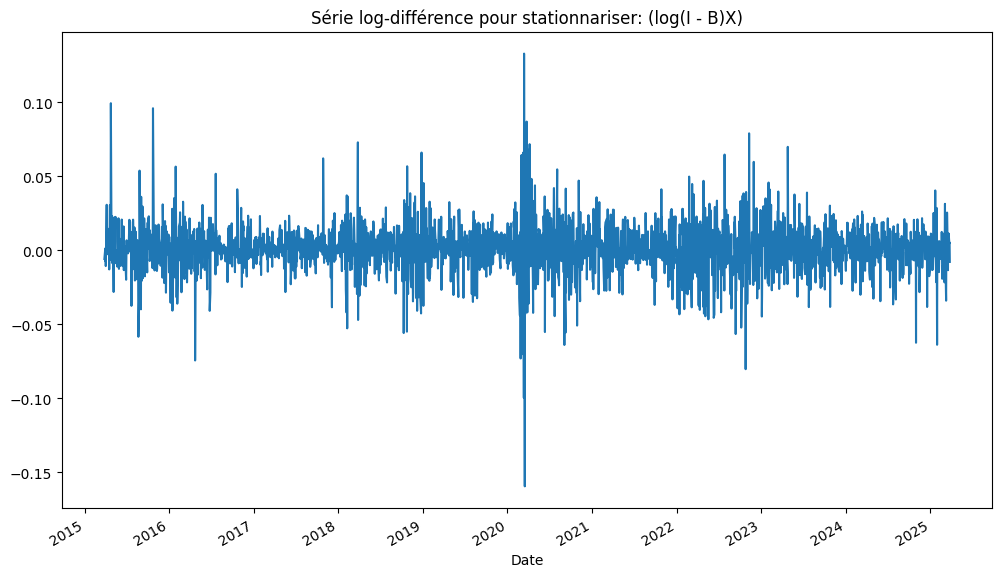

In [11]:
# Log-difference to stationarize the series
plt.figure(figsize=(12,7))
Xt = np.log(data[("Close", ticker)]).diff().dropna()
Xt.plot()
plt.title("Série log-différence pour stationnariser: (log(I - B)X)")
plt.show()

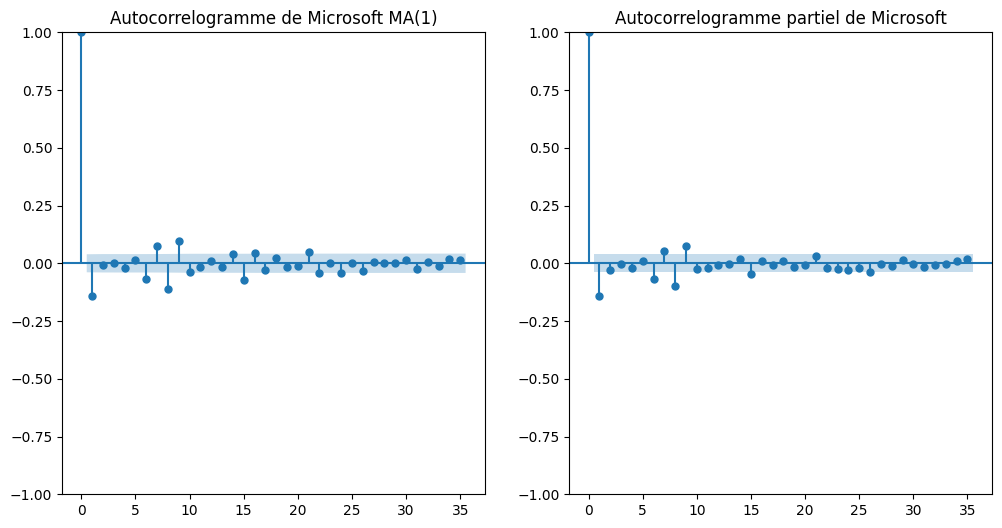

In [12]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

plot_acf(Xt, alpha=.05, ax= axes[0])
axes[0].set_title("Autocorrelogramme de Microsoft MA(1)")
plot_pacf(Xt, alpha=.05, ax=axes[1])
axes[1].set_title("Autocorrelogramme partiel de Microsoft")
plt.show()

On reconnaît un MA(1). On peut voir que des covariances pour h=6,7,8,9 sortent des bandes de confiance mais c'est normal car on est sous des données réelle et que l'IC est à 95% donc naturellement 5/100 fois il peut se tromper. 

Soit **\( P_t \)** la série de prix, **\( X_t \)** la série définie par :

$$ X_t = \log(P_t) - \log(P_{t-1}) $$


Nous observons dans le graphique et par la formule du cours :

$$ \rho(1) = 0.15 \Rightarrow 0.15 = \frac{\theta}{1 + \theta^2} $$

En re´solvons cette équation :

$$ \theta_1  \approx -0.154 $$

$$ \theta_2   \approx -6.513 $$

$$
\text{Comme } \left| \theta_1 \right| < 1 \text{ et } \left| \theta_2 \right| > 1,  
\text{ nous retenons } \theta = -0.154 \text{ car cela garantit l'inversibilité du processus MA(1).}
$$

De plus, l'hypothèse nulle avec laquelle les bornes de l'IC sont calculées considère un bruit blanc fort, ce qui n'est probablement pas le cas vu la nature de nos données donc on n'est pas choquées des résultats, ça correspond bien à un MA(1).

On voit que la covariance entre Xt et Xt-1 (h=1) est négative parce que que le rendement de l'action hier soit positif veut pas dire que celui d'aujourd'hui va l'être aussi. Résultat cohérent aussi.

Mais cela nous semble bizarre parce que ça peut pas être sis imple de devenir riche.

#### Montrons que la série Xt-Xt-2 pour tout t, suit un MA(2)



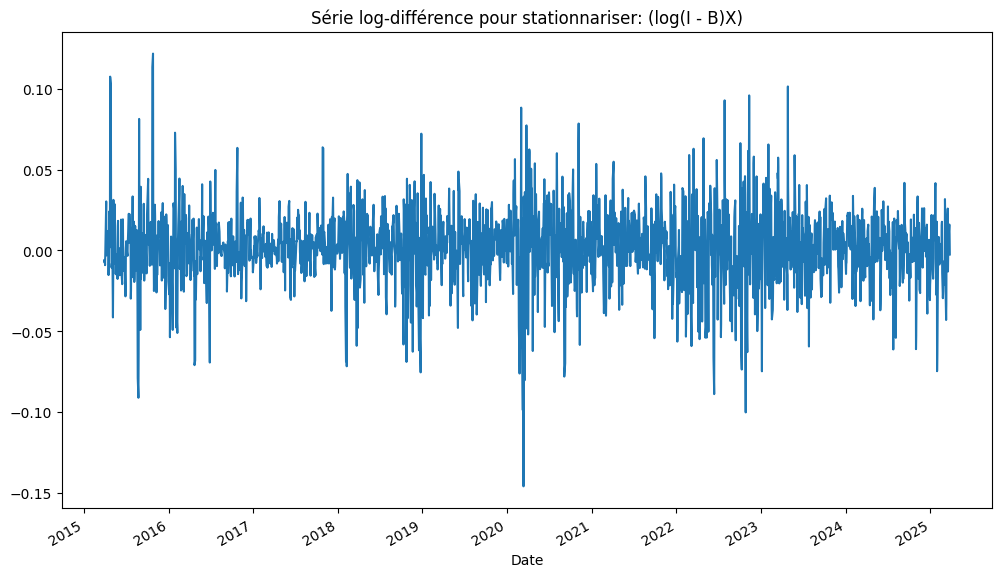

In [13]:
# Log-difference to stationarize the series
plt.figure(figsize=(12,7))
Yt = np.log(data[("Close", ticker)]).diff(2).dropna()
Yt.plot()
plt.title("Série log-différence pour stationnariser: (log(I - B)X)")
plt.show()


**\( Y_t \)** la série des différences de **\( X_t \)** définie par :

$$ Y_t = \log(P_t) - \log(P_{t-2}) $$
$$Y_t = \log(P_t) - \log(P_{t-1}) +  \log(P_{t-1}) - \log(P_{t-2}) $$
$$ Y_t = X_t + X_{t-1} $$

On suppose que **\( X_t \)** suit un processus MA(1) :

$$ X_t = Z_t - \theta Z_{t-1} $$

où **\( Z_t \)** est un bruit blanc. En remplaçant cette expression dans **\( Y_t \)** :

$$ Y_t = (Z_t - \theta Z_{t-1}) + (Z_{t-1} - \theta Z_{t-2}) $$

$$ Y_t = Z_t - \theta Z_{t-1} + Z_{t-1} - \theta Z_{t-2} $$

$$ Y_t = Z_t + (1 - \theta) Z_{t-1} - \theta Z_{t-2} $$

On reconnaît ici un **MA(2)** avec :

$$ \theta_1 = 1 - \theta $$

$$ \theta_2 = -\theta $$


Ainsi, pour le processus MA(2) :

$$ \theta_1 = 1 - (-0.154) = 1.154 $$

$$ \theta_2 = -(-0.154) = 0.154 $$

Pour **\( \rho(2) \)**, nous utilisons la formule :

$$ \rho(2) = \frac{-\theta_2}{1 + \theta_1^2 + \theta_2^2} $$

$$ \rho(2) = \frac{-0.154}{2.356} $$

$$ \rho(2) \approx -0.065  $$ 
-0.065 semble être la valeur pour h=2 du graphique

Le modèle **MA(2)** de **\( Y_t \)** est donc :

$$ Y_t = Z_t + 1.154 Z_{t-1} + 0.154 Z_{t-2} $$

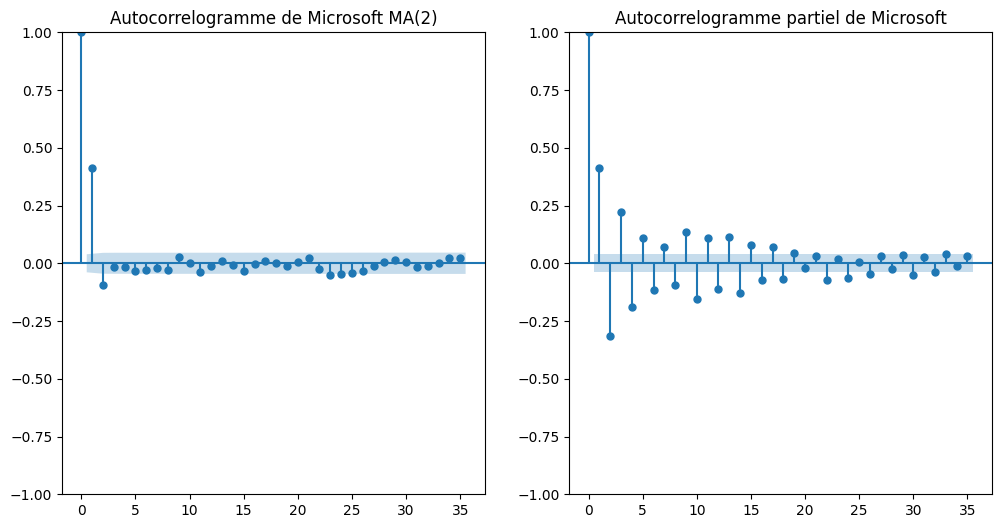

In [14]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

plot_acf(Yt, alpha=.05, ax= axes[0])
axes[0].set_title("Autocorrelogramme de Microsoft MA(2)")
plot_pacf(Yt, alpha=.05, ax=axes[1])
axes[1].set_title("Autocorrelogramme partiel de Microsoft")
plt.show()